# Model Risk Pipeline

This notebook aims at demonstrating how one might employ the default pipeline for ML tasks. Hyperparameter optimization relies on `hyperopt` library, we expect to add `optuna` support in the future.

__Inputs:__

1. Dataset

__Ouputs:__

1. Optimal pipeline structure, as obtained by `hyperopt`
2. Optimal model

## 1. Technicals

In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from hyperopt import hp

from modules.utils import gini_score
from modules.defaults import get_default_modules
from modules.pipeline import PipeHPOpt

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [2]:
seed = 42

## 2. Import Dataset

In [3]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [4]:
with open('../datasets/01_german/factors.json') as json_file:
    factors_dict = json.load(json_file)

In [5]:
factors_dict['cat_vals']

['cheq_acc',
 'cred_hist',
 'purp',
 'save_acc',
 'empl_t',
 'pers_status',
 'guarant_flg',
 'prop',
 'inst_plan',
 'house',
 'job',
 'tel_flg',
 'foreign_flg']

## 3. Define Modules

All the modules that might be part of the pipeline should be defined below (or import them):

In [6]:
# get default modules
pipe_modules = get_default_modules()

## 4. Define Pipeline

### 4.1. Структура Pipeline

Определим структуру самого пайплайна. Словесное описание:
    
1. Энкодинг категориальных переменных:
    + OneHotEncoder
    + WoE
3. Feature Engineering:
    + PCA
    + Kernel PCA
    + Isomap
    + UMAP
    + Combine with Reference (feature multiplication)
    + _отсутствует_
4. Feature Selection:
    + RecursiveFeatureAddition
    + SequentialFeatureSelector
    + SmartCorrelatedSelection
    + _отсутствует_
4. Resampling:
    + Randomised Undersampling (RUS)
    + Randomised Oversampling  (ROS)
    + Synthetic Minority Oversampling Technique (SMOTE)
    + Adaptive Synthetic (ADASYN)
    + _отсутствует_
5. LightGBM

А так это будет выражаться в коде:

In [7]:
pipe_params = {
    # 'missing_vals': 
    'cat_encoding':  hp.choice('cat_encoding', ['OneHot', 'WoE']), # , 'woe' пропустить нельзя из-за наличия кат. пер-х
    'imbalance':     hp.choice('imbalance',    ['skip', 'RUS', 'ROS', 'SMOTE', 'ADASYN']),
    'feat_eng':      hp.choice('feat_eng',     ['skip', 'PCA', 'kPCA', 'Isomap', 'UMAP']), # , 'CombWRef' # удалил, т.к. долго считается
    # 'feat_filter':   hp.choice() -- unstable, low quality (SHAP, IV, feat_importance, ...) 
    'feat_sel':      hp.choice('feat_sel',     ['skip', 'SeqFearSel', 'RecFeatAdd', 'SmartSel']), # 'SelShuffl' is omitted, since it might drop all Xs
    'lgbm':          'lgbm'
}

Заметим, что 'skip' позволяет игнорировать соответствующий шаг в пайплайне. Названия типа `"onehot"` должны совпадать с названиями в словаре `modules`, который мы определили на Шаге 3.

### 4.2. Гиперпараметры модулей

В следующий словарь добавляем гиперпараметры каждого из модулей, которые мы хотим оптимизировать. Названия строятся следующи образом:

`<Название модуля>__<название параметра>`

Например, чтобы задать параметр `num_leaves` модуля lgbm, трубуется добваить значение с ключем `lgbm__num_leaves`.

In [8]:
set_params = {
    # OneHotEncoder does not need hyperparams
    # RecFeatAdd might be redefined to receive a correct estimator
    # PCA
    'DimRed__PCA__n_components':      hp.choice('PCA__n_components',      np.arange(2, 11)),
    'DimRed__PCA__whiten':            hp.choice('PCA__whiten',            [True, False]),
    'DimRed__PCA__svd_solver':        hp.choice('PCA__svd_solver',        ['full', 'arpack', 'auto', 'randomized']),
    
    # kPCA
    'DimRed__kPCA__n_components':     hp.choice('kPCA__n_components',     np.arange(5, 11)),
    'DimRed__kPCA__kernel':           hp.choice('kPCA__kernel',           ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']),
    
    # Isomap
    'DimRed__Isomap__n_neighbors':    hp.choice('Isomap__n_neighbors',    np.arange(2, 11)),
    'DimRed__Isomap__n_components':   hp.choice('Isomap__n_components',   np.arange(2, 5)),
    'DimRed__Isomap__path_method':    hp.choice('Isomap__path_method',    ['auto', 'FW', 'D']),
    
    # UMAP
    'DimRed__UMAP__n_neighbors':      hp.choice('UMAP__n_neighbors',      np.arange(2, 11)),
    'DimRed__UMAP__n_components':     hp.choice('UMAP__n_components',     np.arange(2, 11)),
    'DimRed__UMAP__min_dist':         hp.choice('UMAP__min_dist',         np.arange(0.05, 1, 0.05)),
    
    # LightGBM
    'lgbm__learning_rate':    hp.choice('lgbm__learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'lgbm__num_leaves':       hp.choice('lgbm__num_leaves',       np.arange(5, 16, 1, dtype=int)),
    'lgbm__reg_alpha':        hp.choice('lgbm__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'lgbm__reg_lambda':       hp.choice('lgbm__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'lgbm__n_estimators':     100
}

Чтобы параметры можно было оптимизировать, модули должны иметь метод `.set_params()`.

### 4.3. Подстановка оптимизационной задачи

In [9]:
# technicals — define minimization task
pipe_para = dict()
pipe_para['pipe_params']    = pipe_params
pipe_para['set_params']     = set_params
pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.roc_auc_score(y, pred)
# pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.log_loss(y, pred)

In [10]:
%%capture --no-stdout
hpoptimizer = PipeHPOpt(X_train, y_train, modules=pipe_modules, mode='kfold', n_folds = 4, seed=seed)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=Trials(), algo=tpe.suggest, max_evals=10)

100%|███████████████████████████████████████████████| 10/10 [03:18<00:00, 19.81s/trial, best loss: -0.7701240836375024]


## 5. Results Analysis

In [11]:
hpoptimizer.get_best_params()

{'loss_func': <function __main__.<lambda>(y, pred)>,
 'pipe_params': {'cat_encoding': 'WoE',
  'feat_eng': 'kPCA',
  'feat_sel': 'skip',
  'imbalance': 'SMOTE',
  'lgbm': 'lgbm'},
 'set_params': {'DimRed__Isomap__n_components': 3,
  'DimRed__Isomap__n_neighbors': 2,
  'DimRed__Isomap__path_method': 'D',
  'DimRed__PCA__n_components': 4,
  'DimRed__PCA__svd_solver': 'arpack',
  'DimRed__PCA__whiten': False,
  'DimRed__UMAP__min_dist': 0.1,
  'DimRed__UMAP__n_components': 2,
  'DimRed__UMAP__n_neighbors': 6,
  'DimRed__kPCA__kernel': 'sigmoid',
  'DimRed__kPCA__n_components': 5,
  'lgbm__learning_rate': 0.1,
  'lgbm__n_estimators': 100,
  'lgbm__num_leaves': 11,
  'lgbm__reg_alpha': 2,
  'lgbm__reg_lambda': 4}}

In [12]:
best_mdl = hpoptimizer.get_best_model()
best_mdl

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Pipeline(steps=[('WoE', WoEEncoder_adj()),
                ('kPCA',
                 <modules.preprocessing.DimensionReducer object at 0x000001CCA6564B48>),
                ('SMOTE', SMOTE(random_state=42)),
                ('lgbm',
                 LGBMClassifier(num_leaves=11, random_state=42, reg_alpha=2,
                                reg_lambda=4))])

In [14]:
gini_score(y_train, best_mdl.predict_proba(X_train)[:, 1])
gini_score(y_test, best_mdl.predict_proba(X_test)[:, 1])

Gini: 0.9224162887194827
Gini: 0.6249549224666426


0.6249549224666426

In [15]:
[r['loss'] for r in trials.results]

[-0.6100505302785196,
 -0.7392480722529629,
 -0.7608021917188518,
 -0.7626486355273503,
 -0.6979022915182889,
 -0.6161658963211276,
 -0.7251588231158989,
 -0.7436826083729274,
 -0.7701240836375024,
 -0.6822371267211811]

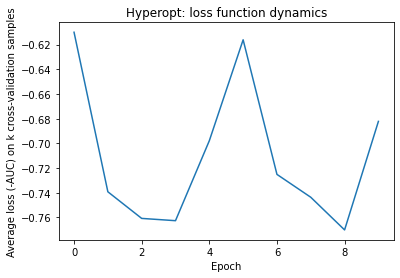

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(np.array([r['loss'] for r in trials.results]))
plt.title('Hyperopt: loss function dynamics')
plt.xlabel('Epoch')
plt.ylabel('Average loss (-AUC) on k cross-validation samples')
plt.show()
plt.savefig('loss_dynamics_hp_1000_tpe_suggest.png')